# Measuring the Metallicty/Abundance for BreakBird galaxies 
Part 1: MaNGA data

In [1]:
from marvin.tools.cube import Cube
from marvin.tools import Maps
import numpy as np
import matplotlib.pyplot as plt

INFO: No release version set. Setting default to DR15


/Users/mmckay/conda/envs/astroconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mmckay/conda/envs/astroconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
manga_id_list = ['1-122304','1-48136','1-255878','1-284526','1-631278','1-633990','1-135054']

In [3]:
#Download MaNGA files locally
for ids in manga_id_list:
    cube = Cube(mangaid=ids)
    cube.download()

/Users/mmckay/conda/envs/astroconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


SDSS_ACCESS> syncing... please wait


KeyboardInterrupt: 

In [4]:
#Confirm that the files are local
for ids in manga_id_list:
    cube = Cube(mangaid=ids)
    print(cube)

<Marvin Cube (plateifu='9183-3703', mode='local', data_origin='file')>
<Marvin Cube (plateifu='10001-3702', mode='local', data_origin='file')>
<Marvin Cube (plateifu='8254-1902', mode='local', data_origin='file')>
<Marvin Cube (plateifu='8465-9102', mode='local', data_origin='file')>
<Marvin Cube (plateifu='8595-3703', mode='local', data_origin='file')>
<Marvin Cube (plateifu='8312-12704', mode='local', data_origin='file')>
<Marvin Cube (plateifu='8550-12703', mode='local', data_origin='file')>


# Get the OII, OIII dobulet and Hbeta maps -----> calculate the R23 Pagel et al. (1979) described in Kewley & Dopita (2002)



In [112]:
#Calculate the R23 ratio
def R23_ratio(manga_id):
    galaxy = Maps(mangaid=manga_id)
    print(galaxy) 
    hB_flux_map = galaxy['emline_gflux_hb_4862']
    OII_flux_map = galaxy['emline_gflux_oiid_3728']
    OIII_4960_flux_map = galaxy['emline_gflux_oiii_4960']
    OIII_5008_flux_map = galaxy['emline_gflux_oiii_5008']
    
    R23 = (OII_flux_map + OIII_4960_flux_map + OIII_5008_flux_map) / hB_flux_map
    return R23

#Calculate the R/Reff ratio
def R_Reff_ratio(manga_id):
    Reff = float(Maps(mangaid=manga_id).header['reff'])
    R = Maps(mangaid=manga_id).spx_ellcoo_elliptical_radius.value #arcsecs
    radius_ratio = R / Reff
    return radius_ratio

def bpt_sf_spaxels_only_mask(manga_id):
    galaxy = Maps(mangaid=manga_id)
    #Get BPT diagram measurments to use use for the mask
    snrdict = {'ha':5,'nii':2,'oi':1}
    masks = galaxy.get_bpt(snr_min=snrdict, return_figure=False, show_plot=False)
    sf = masks['sf']['global']
    haflux_map = galaxy['emline_gflux_ha_6564']
    mask_non_sf = ~sf * haflux_map.pixmask.labels_to_value('DONOTUSE')
    sf_mask = haflux_map.mask | mask_non_sf
    return haflux_map, sf_mask
    
def bpt_comp_spaxels_only_mask(manga_id):
    galaxy = Maps(mangaid=manga_id)
    #Get BPT diagram measurments to use use for the mask
    snrdict = {'ha':5,'nii':2,'oi':1}
    masks = galaxy.get_bpt(snr_min=snrdict, return_figure=False, show_plot=False)
    comp = masks['comp']['global']
    haflux_map = galaxy['emline_gflux_ha_6564']
    mask_non_comp = ~comp * haflux_map.pixmask.labels_to_value('DONOTUSE')
    comp_mask = haflux_map.mask | mask_non_comp
    return haflux_map, comp_mask    
    
    
def bpt_agn_spaxels_only_mask(manga_id):
    galaxy = Maps(mangaid=manga_id)
    #Get BPT diagram measurments to use use for the mask
    snrdict = {'ha':5,'nii':2,'oi':1}
    masks = galaxy.get_bpt(snr_min=snrdict, return_figure=False, show_plot=False)
    agn = masks['agn']['global']
    haflux_map = galaxy['emline_gflux_ha_6564']
    mask_non_agn = ~agn * haflux_map.pixmask.labels_to_value('DONOTUSE')
    agn_mask = haflux_map.mask | mask_non_agn
    return haflux_map, agn_mask    
        
    
def apply_mask_to_map(maps, mask): #apply mask to the emission line maps including Enhanced maps
    maps_val = maps.value 
    maps_val[mask > mask.min()] = None
    return maps_val




### Subplot of R23 maps for total(non-masked), sf, comp, and agn spaxels and the radial profiles of R23 of each map

In [119]:
def bpt_spaxels_subplot(manga_id, vmin, vmax):
    # Specify the galaxy from the list
    #manga_id = manga_id_list[0]
    
    # Calculate the R23 w/o mask
    R23_map_full = R23_ratio(manga_id)
    R23_map_full.plot()
    
    #Making sf, comp, agn mask
    haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=sf_mask)
    
    haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=comp_mask)
    
    haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=agn_mask)
    
    #Calculate R/Reff
    #R_ratio = R_Reff_ratio(manga_id)
    
    #plt.imshow(R23_map.value)
    
    #Apply mask the R23 ratios
    R23_map_sf = apply_mask_to_map(R23_ratio(manga_id), sf_mask)
    R23_map_comp = apply_mask_to_map(R23_ratio(manga_id), comp_mask)
    R23_map_agn = apply_mask_to_map(R23_ratio(manga_id), agn_mask)
    
    #Make subplot
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25, 5))
    #vmin = 0
    #vmax = 13.5
    
    #All spaxels(No mask/No vetting)
    img1 = ax0.imshow(R23_map_full.value, aspect="auto", vmin=vmin, vmax=vmax)
    ax0.title.set_text('{} all spaxels'.format(manga_id))
    ax0.set_xlabel('Spaxel')
    ax0.set_ylabel('Spaxel')
    fig.colorbar(img1, ax=ax0).set_label(label='$R_{23}$', fontsize=12)
    fig.tight_layout(h_pad=4)
    ax0.invert_yaxis()
    #plt.gca().invert_yaxis()
    
    #SF map
    img2 = ax1.imshow(R23_map_sf, aspect="auto", vmin=vmin, vmax=vmax)
    ax1.title.set_text('{} SF'.format(manga_id))
    ax1.set_xlabel('Spaxel')
    ax1.set_ylabel('Spaxel')
    fig.colorbar(img2, ax=ax1).set_label(label='$R_{23}$', fontsize=12)
    fig.tight_layout(h_pad=4)
    ax1.invert_yaxis()
    
    
    #Comp map
    img3 = ax2.imshow(R23_map_comp, aspect="auto", vmin=vmin, vmax=vmax)
    ax2.title.set_text('{} Comp'.format(manga_id))
    ax2.set_xlabel('Spaxel')
    ax2.set_ylabel('Spaxel')
    fig.colorbar(img3, ax=ax2).set_label(label='$R_{23}$', fontsize=12)
    fig.tight_layout(h_pad=4)
    ax2.invert_yaxis()
    
    
    #AGN map
    img4 = ax3.imshow(R23_map_agn, aspect="auto", vmin=vmin, vmax=vmax)
    ax3.title.set_text('{} AGN'.format(manga_id))
    ax3.set_xlabel('Spaxel')
    ax3.set_ylabel('Spaxel')
    fig.colorbar(img4, ax=ax3).set_label(label='$R_{23}$', fontsize=12)
    fig.tight_layout(h_pad=4)
    ax3.invert_yaxis()
    plt.show()
    
    return()
    
    
    
    #print(R23_map_full.value == R23_map_sf)
    
    
    

In [134]:
def R23_radial_profile(mangaid, ymin, ymax):
    # Calculate the R23 w/o mask
    R23_map_full = R23_ratio(manga_id)
    #R23_map_full.plot()
    
    #Making sf, comp, agn mask
    haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=sf_mask)
    
    haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=comp_mask)
    
    haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
    #haflux_map.plot(mask=agn_mask)
    
    #Calculate R/Reff
    R_ratio = R_Reff_ratio(manga_id)
    
    #plt.imshow(R23_map.value)
    
    #Apply mask the R23 ratios
    R23_map_sf = apply_mask_to_map(R23_ratio(manga_id), sf_mask)
    R23_map_comp = apply_mask_to_map(R23_ratio(manga_id), comp_mask)
    R23_map_agn = apply_mask_to_map(R23_ratio(manga_id), agn_mask)
    
    plt.scatter(R_ratio, R23_map_full.value, color='blue', alpha=0.3)
    plt.ylim(ymin,ymax)
    plt.title('R23 radial profile All spaxels(non-masked)')
    plt.ylabel('R23')
    plt.xlabel('R/R_e')
    plt.show()
    plt.clf()
    
    plt.scatter(R_ratio, R23_map_sf, color='blue', alpha=0.3)
    plt.scatter(R_ratio, R23_map_comp, color='green', alpha=0.3)
    plt.scatter(R_ratio, R23_map_agn, color='red', alpha=0.3)
    plt.title('R23 radial profile')
    plt.ylabel('R23')
    plt.xlabel('R/R_e')
    plt.ylim(ymin,ymax)
    plt.show()

In [135]:
#bpt_spaxels_subplot(manga_id_list[0], vmin=0, vmax=13.5)
#bpt_spaxels_subplot(manga_id_list[1], vmin=0, vmax=9.0)
#bpt_spaxels_subplot(manga_id_list[2], vmin=0, vmax=7)
#bpt_spaxels_subplot(manga_id_list[3], vmin=0, vmax=8)
#bpt_spaxels_subplot(manga_id_list[4], vmin=0, vmax=22)
#bpt_spaxels_subplot(manga_id_list[5], vmin=0, vmax=8)
#bpt_spaxels_subplot(manga_id_list[6], vmin=0, vmax=8)

<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


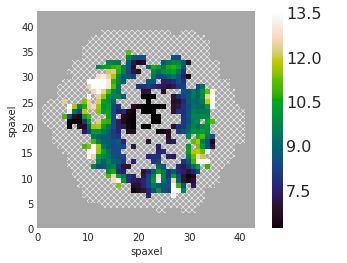

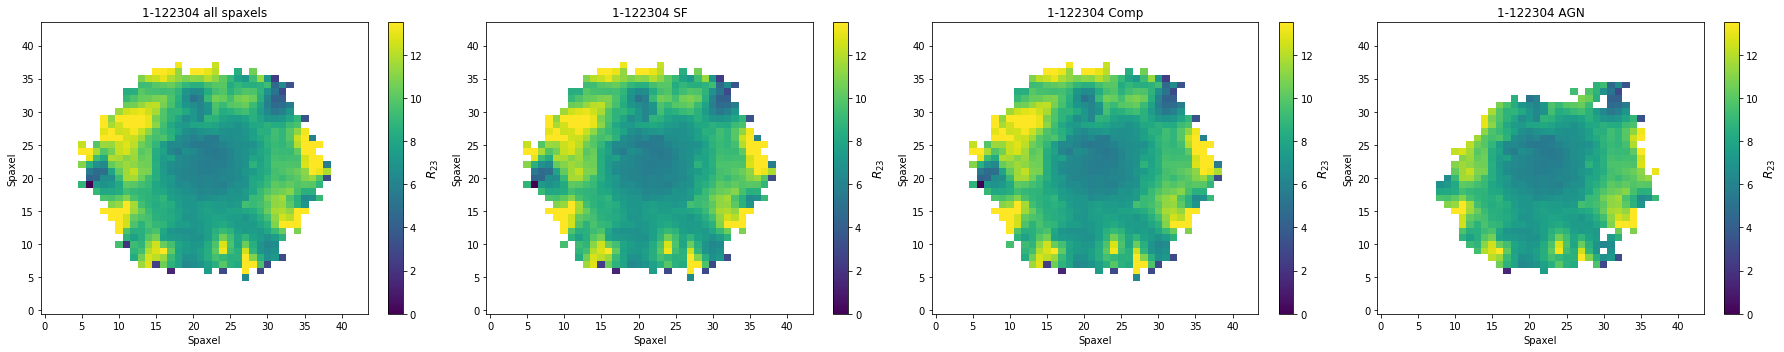

<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


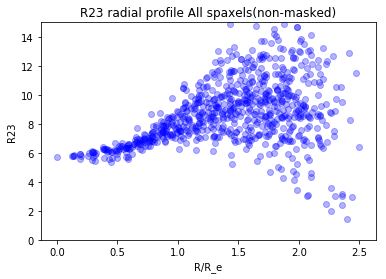

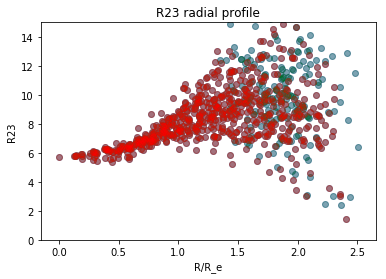

In [136]:
manga_id = manga_id_list[0]
bpt_spaxels_subplot(manga_id, vmin=0, vmax=13.5)
R23_radial_profile(manga_id, ymin=0, ymax=15)


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


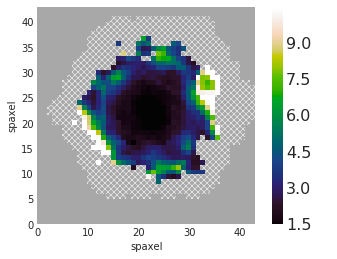

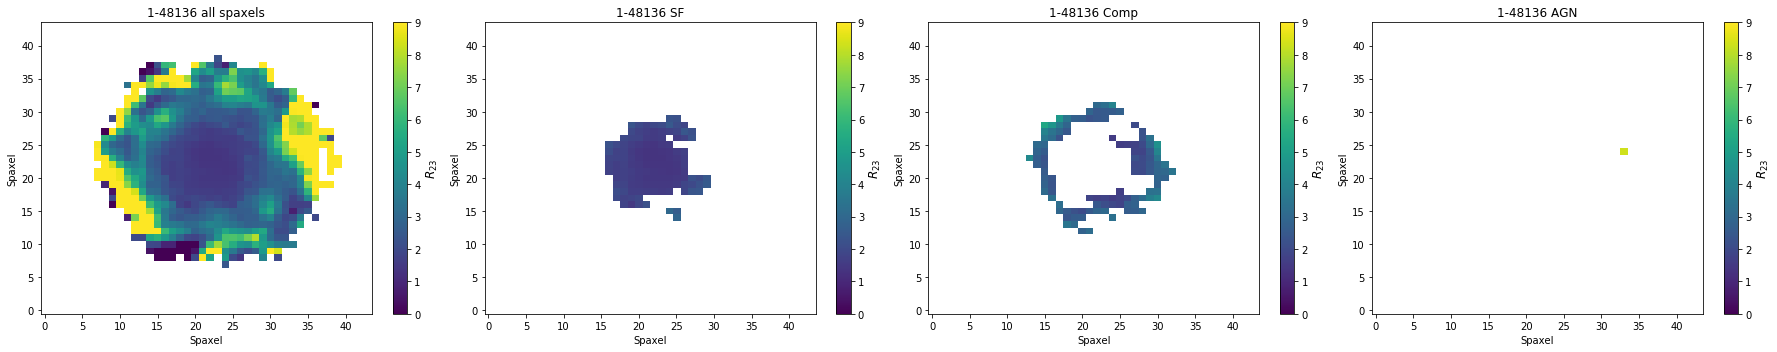

<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


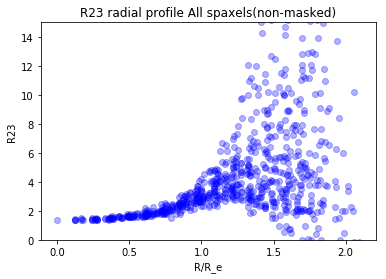

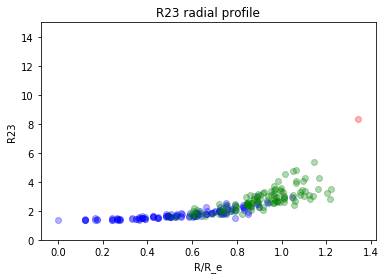

In [137]:
manga_id = manga_id_list[1]
bpt_spaxels_subplot(manga_id_list[1], vmin=0, vmax=9.0)
R23_radial_profile(manga_id, ymin=0, ymax=15)

<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


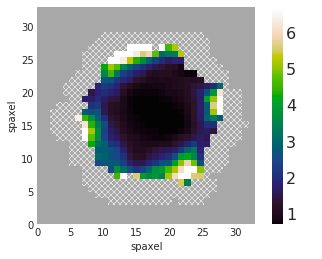

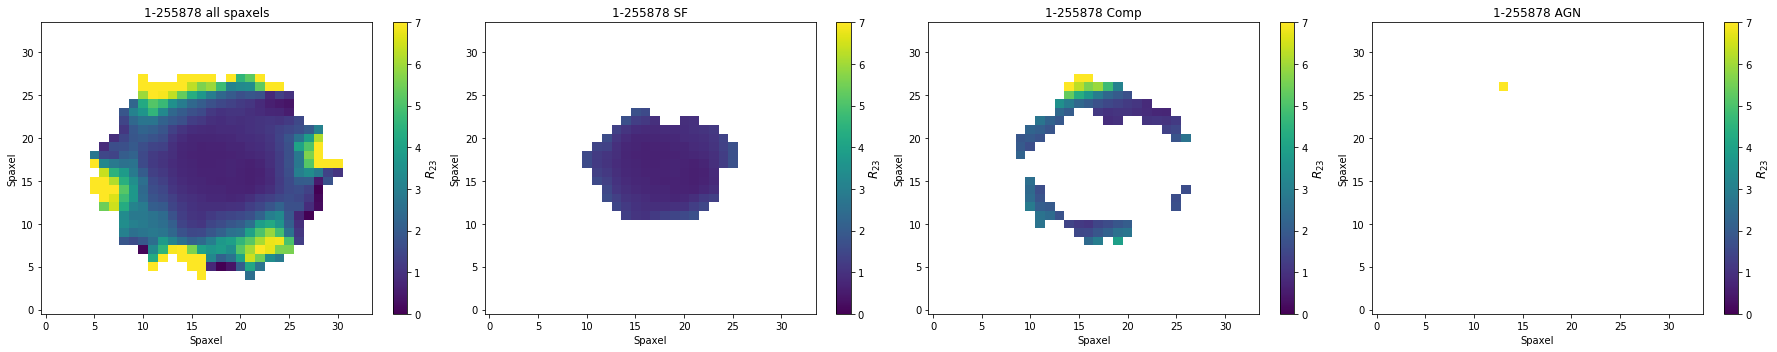

<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


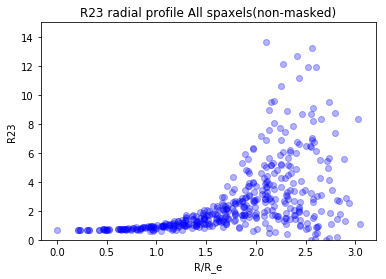

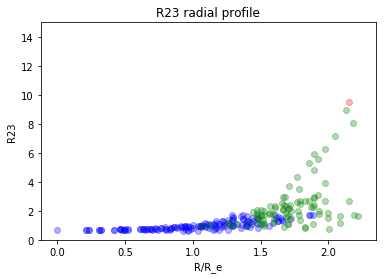

In [138]:
manga_id = manga_id_list[2]
bpt_spaxels_subplot(manga_id_list[2], vmin=0, vmax=7)
R23_radial_profile(manga_id, ymin=0, ymax=15)



<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


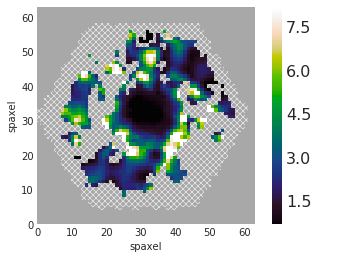

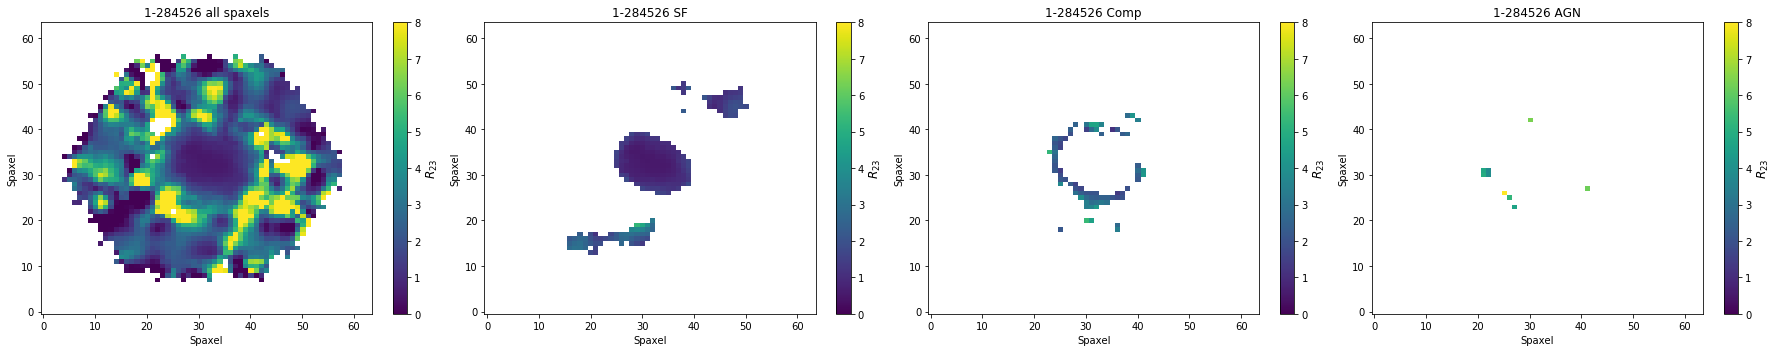

<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.18.254.128', 50589), raddr=('155.101.19.80', 443)>
  self._sock = None


<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


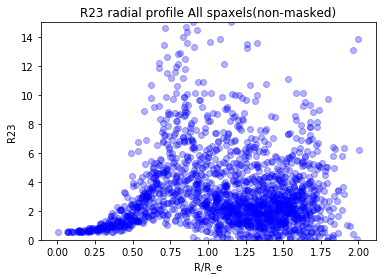

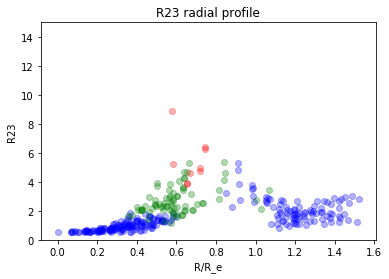

In [139]:
manga_id = manga_id_list[3]
bpt_spaxels_subplot(manga_id_list[3], vmin=0, vmax=8)
R23_radial_profile(manga_id, ymin=0, ymax=15)


<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


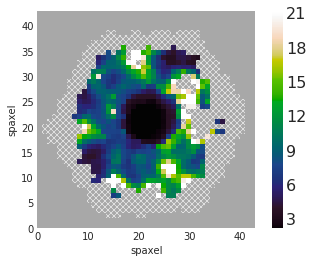

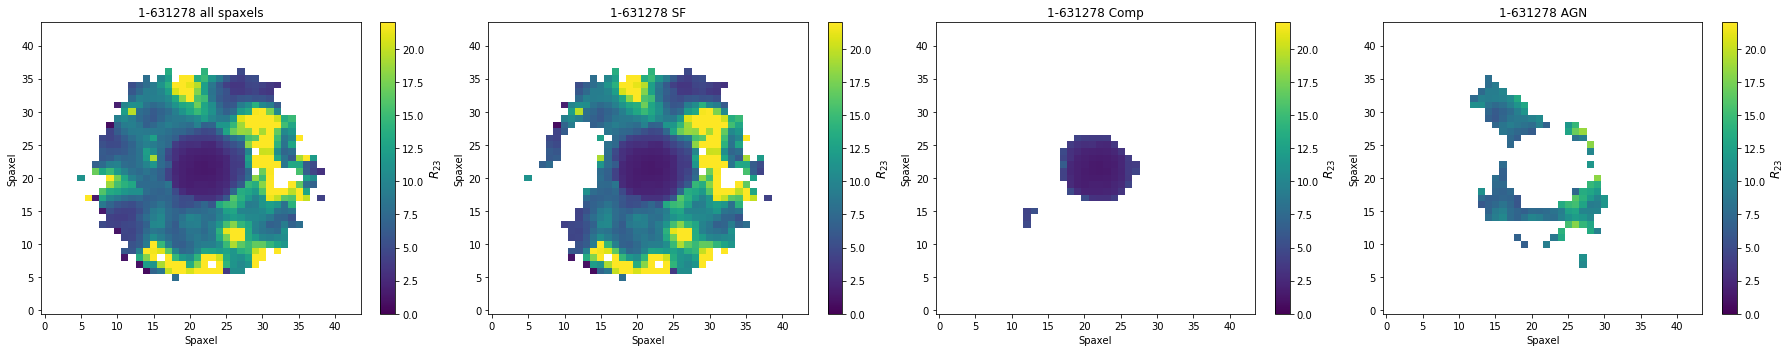

<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


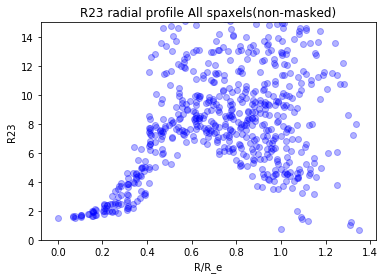

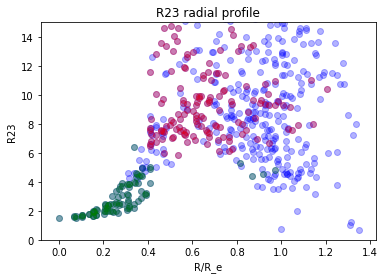

In [140]:
manga_id = manga_id_list[4]
bpt_spaxels_subplot(manga_id_list[4], vmin=0, vmax=22)
R23_radial_profile(manga_id, ymin=0, ymax=15)


<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


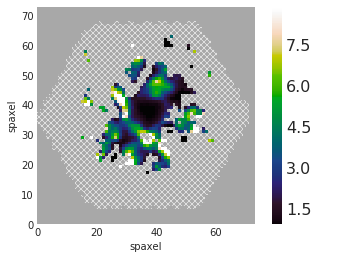

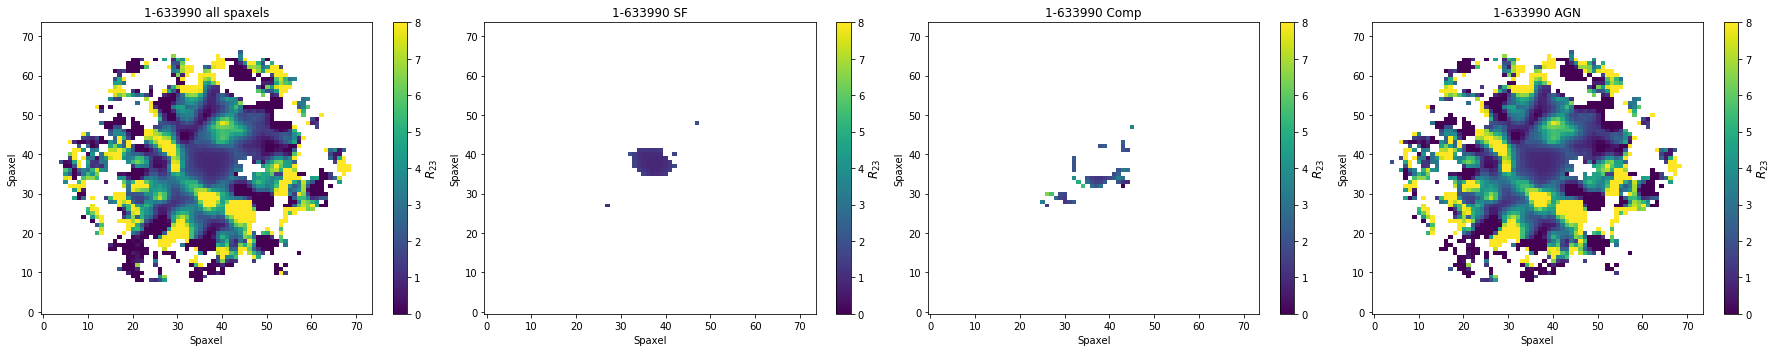

<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


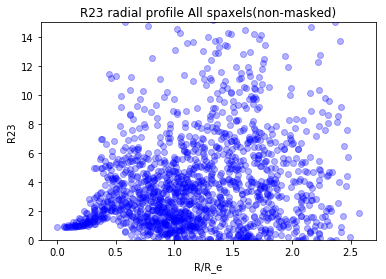

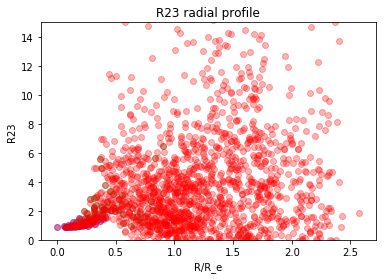

In [141]:
manga_id = manga_id_list[5]
bpt_spaxels_subplot(manga_id_list[5], vmin=0, vmax=8)
R23_radial_profile(manga_id, ymin=0, ymax=15)



<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


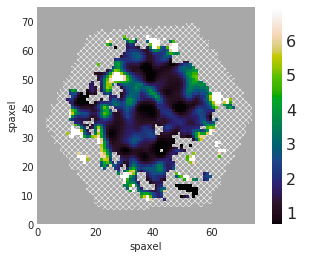

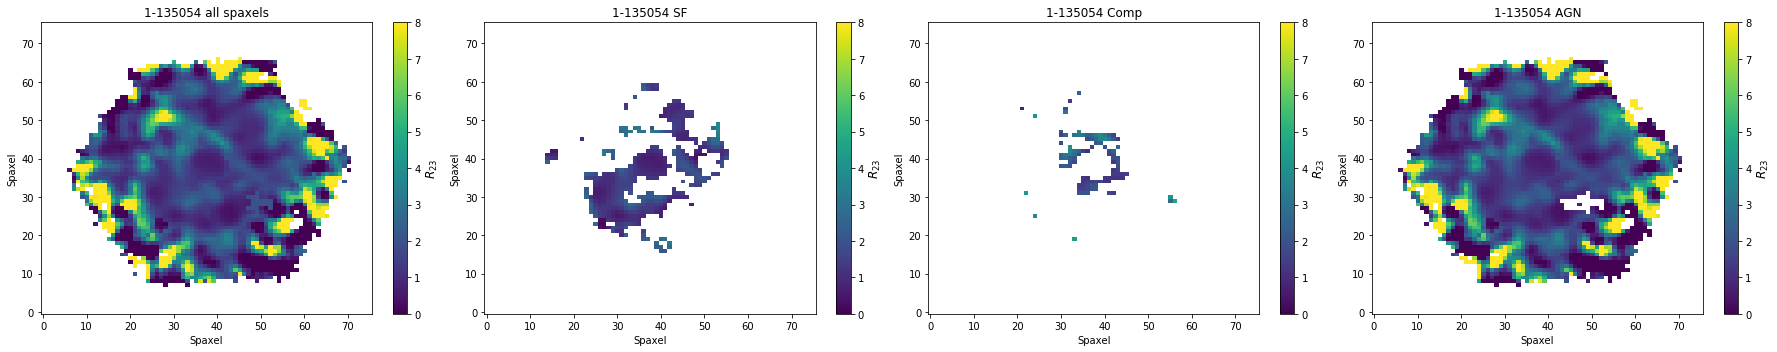

<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


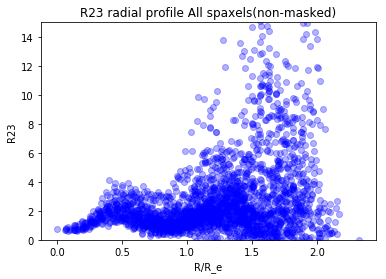

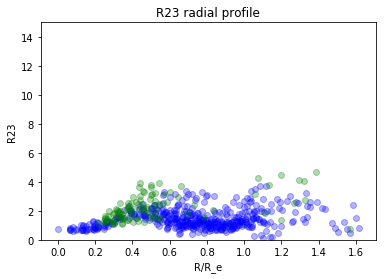

In [107]:
manga_id = manga_id_list[6]
bpt_spaxels_subplot(manga_id_list[6], vmin=0, vmax=8)
R23_radial_profile(manga_id, ymin=0, ymax=15)

<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


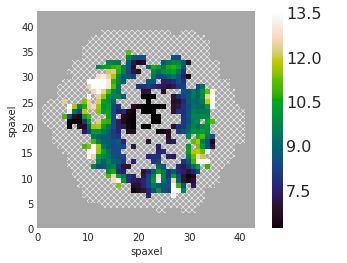

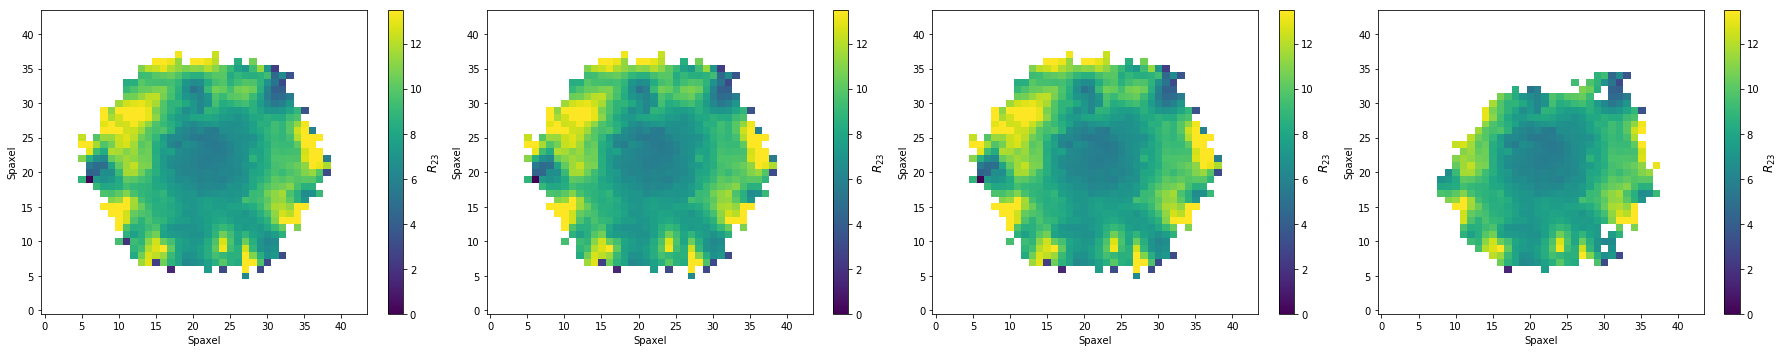

In [53]:
# Specify the galaxy from the list
manga_id = manga_id_list[0]

# Calculate the R23 w/o mask
R23_map_full = R23_ratio(manga_id)
R23_map_full.plot()

#Making sf, comp, agn mask
haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=sf_mask)

haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=comp_mask)

haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=agn_mask)

#Calculate R/Reff
R_ratio = R_Reff_ratio(manga_id)

#plt.imshow(R23_map.value)

#Apply mask the R23 ratios
R23_map_sf = apply_mask_to_map(R23_ratio(manga_id), sf_mask)
R23_map_comp = apply_mask_to_map(R23_ratio(manga_id), comp_mask)
R23_map_agn = apply_mask_to_map(R23_ratio(manga_id), agn_mask)

#Make subplot
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25, 5))
vmin = 0
vmax = 13.5

#All spaxels(No mask/No vetting)
img1 = ax0.imshow(R23_map_full.value, aspect="auto", vmin=vmin, vmax=vmax)
ax0.set_xlabel('Spaxel')
ax0.set_ylabel('Spaxel')
fig.colorbar(img1, ax=ax0).set_label(label='$R_{23}$', fontsize=12)
fig.tight_layout(h_pad=4)
ax0.invert_yaxis()
#plt.gca().invert_yaxis()

#SF map
img2 = ax1.imshow(R23_map_sf, aspect="auto", vmin=vmin, vmax=vmax)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
fig.colorbar(img2, ax=ax1).set_label(label='$R_{23}$', fontsize=12)
fig.tight_layout(h_pad=4)
ax1.invert_yaxis()


#Comp map
img3 = ax2.imshow(R23_map_comp, aspect="auto", vmin=vmin, vmax=vmax)
ax2.set_xlabel('Spaxel')
ax2.set_ylabel('Spaxel')
fig.colorbar(img3, ax=ax2).set_label(label='$R_{23}$', fontsize=12)
fig.tight_layout(h_pad=4)
ax2.invert_yaxis()


#AGN map
img4 = ax3.imshow(R23_map_agn, aspect="auto", vmin=vmin, vmax=vmax)
ax3.set_xlabel('Spaxel')
ax3.set_ylabel('Spaxel')
fig.colorbar(img4, ax=ax3).set_label(label='$R_{23}$', fontsize=12)
fig.tight_layout(h_pad=4)
ax3.invert_yaxis()


#print(R23_map_full.value == R23_map_sf)


plt.scatter()

<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


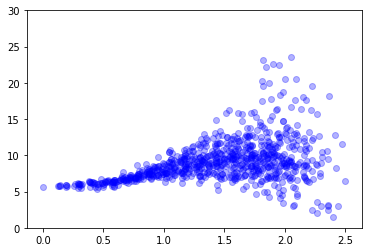

(0, 30)

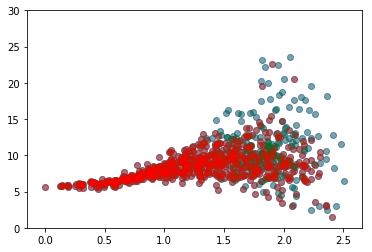

In [82]:
manga_id = manga_id_list[0]


# Calculate the R23 w/o mask
R23_map_full = R23_ratio(manga_id)
#R23_map_full.plot()

#Making sf, comp, agn mask
haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=sf_mask)

haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=comp_mask)

haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
#haflux_map.plot(mask=agn_mask)

#Calculate R/Reff
R_ratio = R_Reff_ratio(manga_id)

#plt.imshow(R23_map.value)

#Apply mask the R23 ratios
R23_map_sf = apply_mask_to_map(R23_ratio(manga_id), sf_mask)
R23_map_comp = apply_mask_to_map(R23_ratio(manga_id), comp_mask)
R23_map_agn = apply_mask_to_map(R23_ratio(manga_id), agn_mask)

plt.scatter(R_ratio, R23_map_full.value, color='blue', alpha=0.3)
plt.ylim(0,30)
plt.show()
plt.clf()

plt.scatter(R_ratio, R23_map_sf, color='blue', alpha=0.3)
plt.scatter(R_ratio, R23_map_comp, color='green', alpha=0.3)
plt.scatter(R_ratio, R23_map_agn, color='red', alpha=0.3)
plt.ylim(0,30)

<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


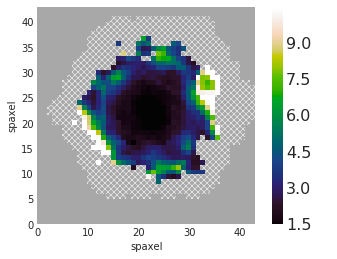

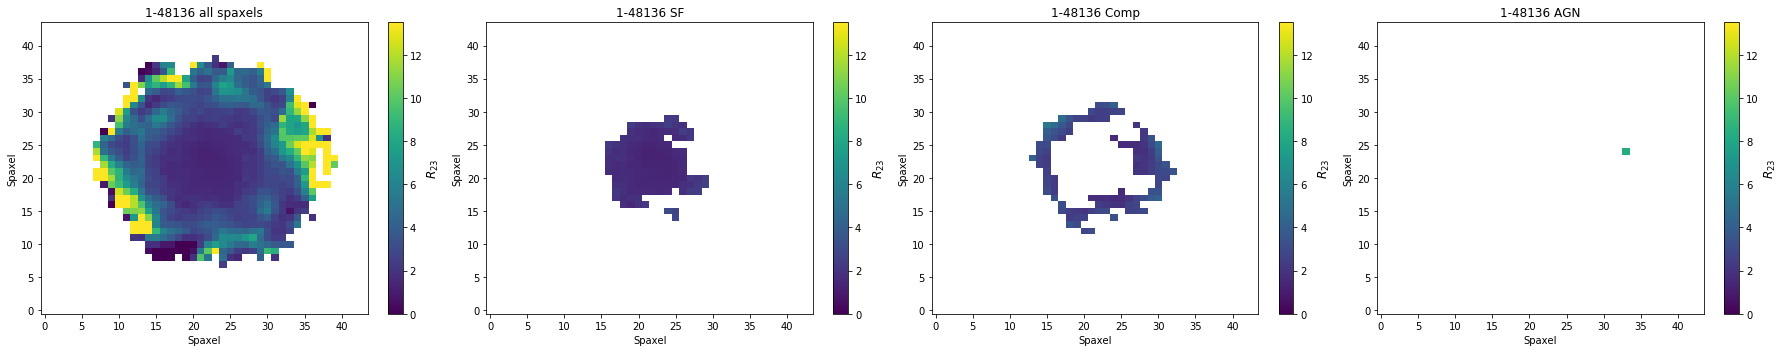

<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


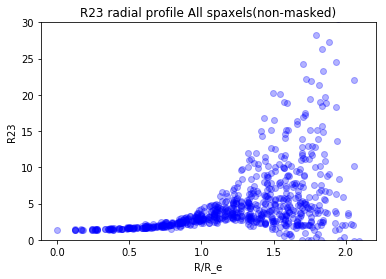

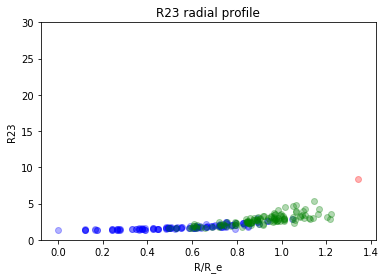

In [93]:
manga_id = manga_id_list[1]
bpt_spaxels_subplot(manga_id, vmin=0, vmax=13.5)
R23_radial_profile(manga_id, ymin=0, ymax=30)



<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
(76, 76)
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


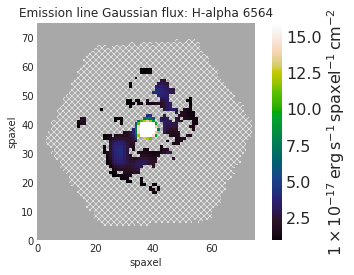

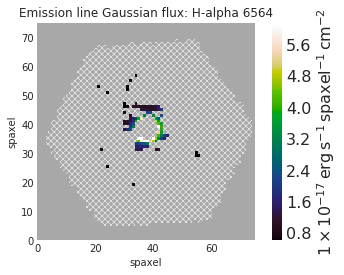

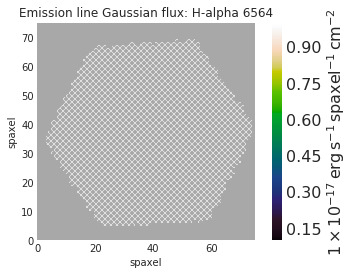

In [229]:
manga_id = manga_id_list[6]
R23_map = R23_ratio(manga_id)


haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
haflux_map.plot(mask=sf_mask)

haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
haflux_map.plot(mask=comp_mask)

haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
haflux_map.plot(mask=agn_mask)


R23_map_sf = R23_ratio(manga_id)
R23_map_sf = R23_map_sf.value
R23_map_sf[sf_mask > sf_mask.min()] = None
#R23_map.plot(mask=sf_mask)

R_ratio = R_Reff_ratio(manga_id)
print(R_ratio.shape)


R23_map_comp = R23_ratio(manga_id)
R23_map_comp = R23_map_comp.value
R23_map_comp[comp_mask > comp_mask.min()] = None


R23_map_agn = R23_ratio(manga_id)
R23_map_agn = R23_map_agn.value
R23_map_agn[agn_mask > agn_mask.min()] = None




Text(0, 0.5, 'R23 ratio')

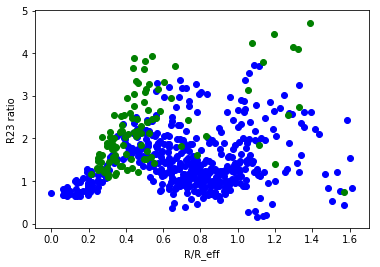

In [232]:
plt.scatter(R_ratio, R23_map_sf, color = 'blue')
plt.scatter(R_ratio, R23_map_comp, color= 'green')
#plt.scatter(R_ratio, R23_map_agn, color= 'red')
plt.xlabel('R/R_eff')
plt.ylabel('R23 ratio')


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


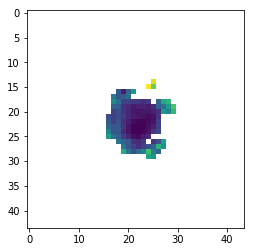

In [164]:
manga_id = manga_id_list[1]
R23_map = R23_ratio(manga_id)
#plt.imshow(R23_map.value)
sf_mask = bpt_sf_spaxels_only_mask(manga_id)[1]
#plt.imshow(sf_mask)

R23_sf_map = apply_mask_to_map(R23_map, sf_mask)
plt.imshow(R23_sf_map)

<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/colors.py:902: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


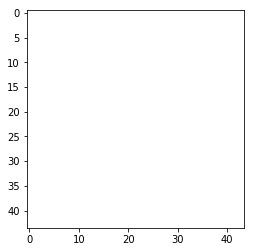

In [199]:
#Make the subplot of R23 maps for total(non-masked), sf, comp, and agn spaxels
manga_id = manga_id_list[1]
R23_map = R23_ratio(manga_id)
#plt.imshow(R23_map.value)


#fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25, 5))
#img = ax0.imshow(R23_map.value, aspect="auto")
##img = ax0.imshow(R23_map.value)
#ax0.set_xlabel('Spaxel')
#ax0.set_ylabel('Spaxel')
##plt.colorbar(im, fraction=0.046, pad=0.04)
#fig.colorbar(img, ax=ax0).set_label(label='R23 Ratio', fontsize=12)#, fraction=0.046, pad=0.04)
##fig.suptitle('{}'.format(i))
#fig.tight_layout(h_pad=4)
#plt.gca().invert_yaxis()

sf_mask = bpt_sf_spaxels_only_mask(manga_id)[1]
comp_mask = bpt_comp_spaxels_only_mask(manga_id)[1]
agn_mask = bpt_agn_spaxels_only_mask(manga_id)[1]

#plt.imshow(sf_mask)

R23_sf_map = apply_mask_to_map(R23_map, sf_mask)
R23_comp_map = apply_mask_to_map(R23_map, comp_mask)
R23_agn_map = apply_mask_to_map(R23_map, agn_mask)

plt.imshow(R23_map.value)

#fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 6))
#img = ax0.imshow(R23_map.value, aspect="auto")
#ax0.set_xlabel('Spaxel')
#ax0.set_ylabel('Spaxel')
##plt.colorbar(im, fraction=0.046, pad=0.04)
#fig.colorbar(img, ax=ax0).set_label(label='R23 Ratio', fontsize=12)#, fraction=0.046, pad=0.04)
##fig.suptitle('{}'.format(i))
#fig.tight_layout(h_pad=4)
#plt.gca().invert_yaxis()

#ax0.scatter(radius_ratio_284526, SFRD_284526.value, label = '{}'.format(i))
#ax0.grid()
##ax0.set_ylim(-0.05e17,0.5e17)
#ax0.set_xlabel('R/R_eff')
#ax0.set_ylabel('${\Sigma}_{SFR}(M_{sun} yr^{-1} kpc^{-2})$')
#ax0.legend()
#
##from mpl_toolkits.axes_grid1 import make_axes_locatable
#
##img1 = ax1.imshow(SFRD_135054.value, vmax = 3e16, aspect="auto")
#img1 = ax1.imshow(SFRD_284526.value, aspect="auto")
#ax1.set_xlabel('Spaxel')
#ax1.set_ylabel('Spaxel')
##plt.colorbar(im, fraction=0.046, pad=0.04)
#fig.colorbar(img1, ax=ax1).set_label(label='${\Sigma}_{SFR}(M_{sun} yr^{-1} kpc^{-2})$', fontsize=12)#, fraction=0.046, pad=0.04)
##fig.suptitle('{}'.format(i))
#fig.tight_layout(h_pad=4)
#plt.gca().invert_yaxis()
#plt.savefig('{}_subplot.jpeg'.format(mangaids[0]))

<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


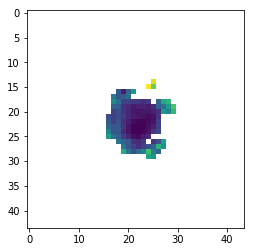

In [147]:


g1_sf_maps = apply_mask_to_map(R23_ratio(manga_id), bpt_sf_spaxels_only_mask(manga_id)[1])

#plt.scatter(R_Reff_ratio(manga_id_list[1]), g1_sf_maps, color = 'blue')
#plt.scatter(R_Reff_ratio(manga_id_list[1]), g1_sf_maps, color = 'blue')

plt.imshow(g1_sf_maps)

/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


(44, 44)
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


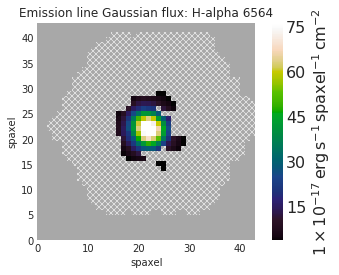

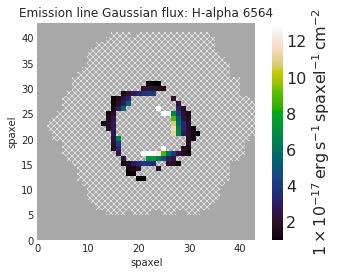

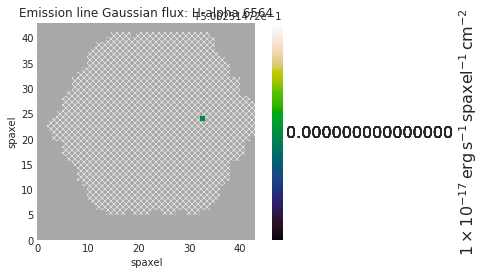

In [208]:


haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id_list[1])
haflux_map.plot(mask=sf_mask)

haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id_list[1])
haflux_map.plot(mask=comp_mask)



haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id_list[1])
haflux_map.plot(mask=agn_mask)


R23_map_sf = R23_ratio(manga_id_list[1])
R23_map_sf = R23_map_sf.value
R23_map_sf[sf_mask > sf_mask.min()] = None
#R23_map.plot(mask=sf_mask)

R_ratio = R_Reff_ratio(manga_id_list[1])
print(R_ratio.shape)


R23_map_comp = R23_ratio(manga_id_list[1])
R23_map_comp = R23_map_comp.value
R23_map_comp[comp_mask > comp_mask.min()] = None


R23_map_agn = R23_ratio(manga_id_list[1])
R23_map_agn = R23_map_agn.value
R23_map_agn[agn_mask > agn_mask.min()] = None






Text(0, 0.5, 'R23 ratio')

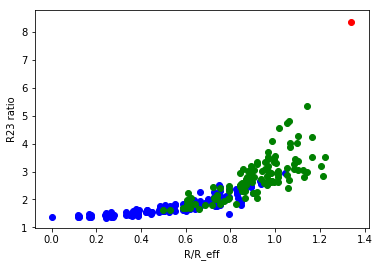

In [211]:
plt.scatter(R_ratio, R23_map_sf, color = 'blue')
plt.scatter(R_ratio, R23_map_comp, color= 'green')
plt.scatter(R_ratio, R23_map_agn, color= 'red')
plt.xlabel('R/R_eff')
plt.ylabel('R23 ratio')
 


<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(44, 44)


Text(0.5, 0, 'R/R_eff')

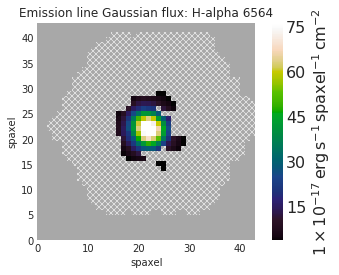

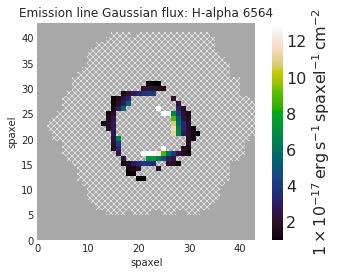

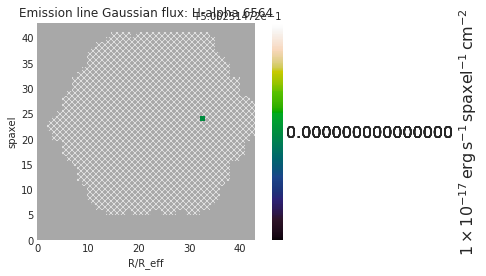

In [205]:
manga_id = manga_id_list[1]
R23_map = R23_ratio(manga_id)

haflux_map, sf_mask = bpt_sf_spaxels_only_mask(manga_id)
haflux_map.plot(mask=sf_mask)

haflux_map, comp_mask = bpt_comp_spaxels_only_mask(manga_id)
haflux_map.plot(mask=comp_mask)

haflux_map, agn_mask = bpt_agn_spaxels_only_mask(manga_id)
haflux_map.plot(mask=agn_mask)

R23_map_sf = apply_mask_to_map(R23_map, sf_mask)
R23_map_comp = apply_mask_to_map(R23_map, comp_mask)
R23_map_agn = apply_mask_to_map(R23_map, agn_mask)

R_ratio = R_Reff_ratio(manga_id)
print(R_ratio.shape)



In [210]:
plt.scatter(R_ratio, R23_map_sf, color = 'blue')
plt.scatter(R_ratio, R23_map_comp, color= 'green')
plt.scatter(R_ratio, R23_map_agn, color= 'red')
plt.xlabel('R/R_eff')

AttributeError: 'numpy.ndarray' object has no attribute 'value'

/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f10db00>)

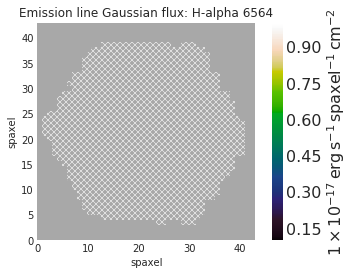

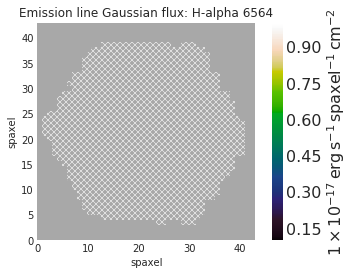

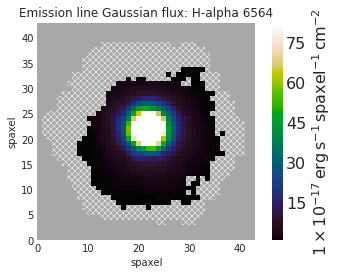

In [105]:
manga_id = manga_id

haflux_map, sf_mask = bpt_sf_spaxels_only(manga_id_list[0])
haflux_map.plot(mask=sf_mask)


haflux_map, comp_mask = bpt_comp_spaxels_only(manga_id_list[0])
haflux_map.plot(mask=comp_mask)



haflux_map, agn_mask = bpt_agn_spaxels_only(manga_id_list[0])
haflux_map.plot(mask=agn_mask)




(44, 44)
(44, 44)
(44, 44)
(44, 44)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a29322cf8>)

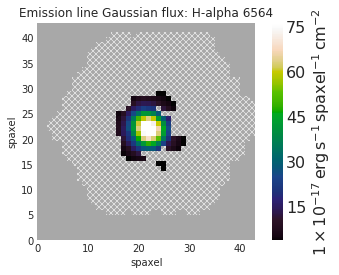

In [53]:
galaxy = Maps(mangaid=manga_id_list[1])
#Get BPT diagram measurments to use use for the mask
snrdict = {'ha':5,'nii':2,'oi':1}
masks = galaxy.get_bpt(snr_min=snrdict, return_figure=False, show_plot=False)
sf = masks['sf']['global']
print(sf.shape)
haflux_map = galaxy['emline_gflux_ha_6564']
print(haflux_map.shape)
mask_non_sf = ~sf * haflux_map.pixmask.labels_to_value('DONOTUSE')
print(mask_non_sf.shape)
sf_mask = haflux_map.mask | mask_non_sf
print(sf_mask.shape)


haflux_map.plot(mask=sf_mask)

/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a289b9400>)

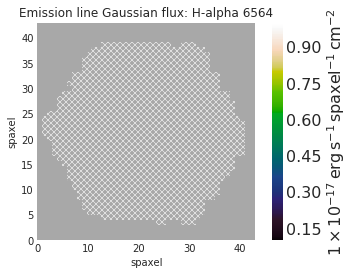

In [32]:
haflux_map, sf_mask = bpt_sf_spaxels_only(manga_id_list[0])





#haflux_map.plot()
#haflux_map = haflux_map[0].value
#haflux_map.plot()



#haflux_map[sf_mask > sf_mask.min()] = None



/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a28a1a0f0>)

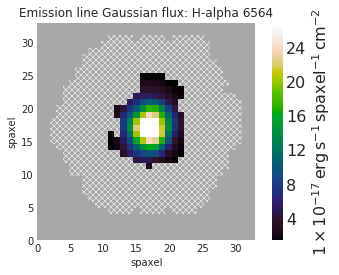

In [34]:
import numpy as np
from marvin.tools import Maps
maps = Maps('8485-1901')
ha = maps.emline_gflux_ha_6564
masks = maps.get_bpt(show_plot=False, return_figure=False)

# Create a bitmask for non-star-forming spaxels by taking the
# complement (`~`) of the BPT global star-forming mask (where True == star-forming)
# and set bit 30 (DONOTUSE) for those spaxels.
mask_non_sf = ~masks['sf']['global'] * ha.pixmask.labels_to_value('DONOTUSE')

# Do a bitwise OR between DAP mask and non-star-forming mask.
mask = ha.mask | mask_non_sf

ha.plot(mask=mask)

In [25]:
print(sf_mask.shape, haflux_map.shape)

(44, 44) (44,)


<Marvin Maps (plateifu='9183-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


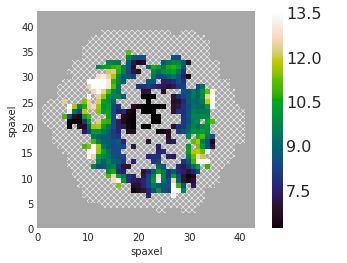

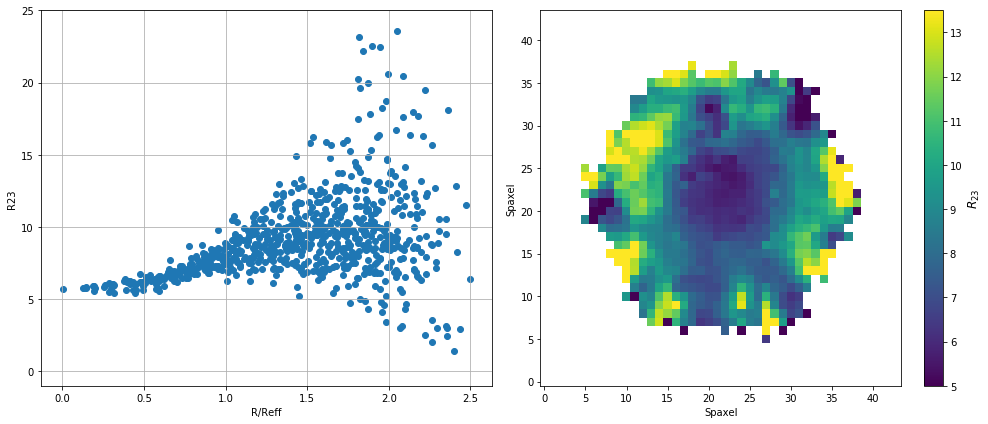

In [118]:
R23_122304 = R23_ratio(manga_id_list[0])
radius_122304 = R_Reff_ratio(manga_id_list[0])

fig, ax = R23_122304.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_122304, R23_122304.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-1,25)
#

img1 = ax1.imshow(R23_122304.value, aspect="auto", vmin=5, vmax=13.5)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()



<Marvin Maps (plateifu='10001-3702', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


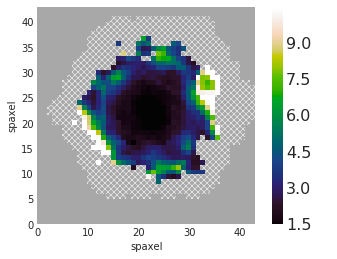

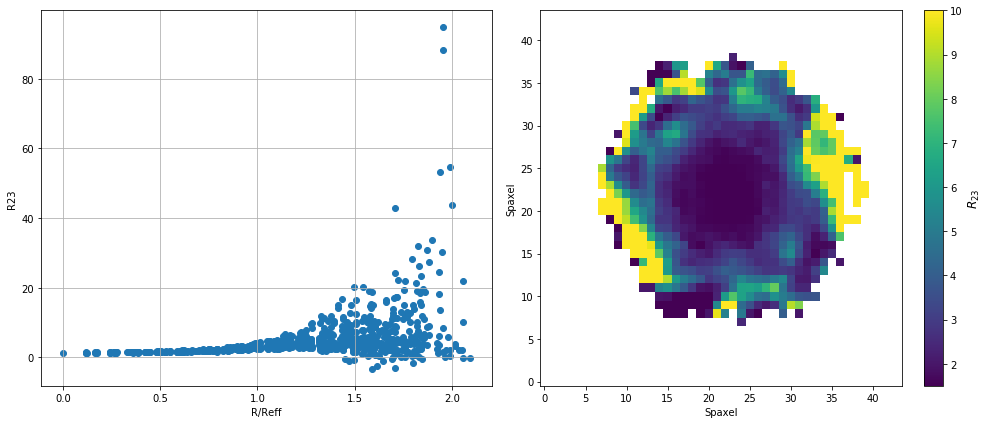

In [119]:
R23_48136 = R23_ratio(manga_id_list[1])
radius_48136 = R_Reff_ratio(manga_id_list[1])

fig, ax = R23_48136.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_48136, R23_48136.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
#ax0.set_ylim(-1,25)
#

img1 = ax1.imshow(R23_48136.value, aspect="auto", vmin=1.5, vmax=10)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()

<Marvin Maps (plateifu='8254-1902', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
(34, 34)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


(34, 34)


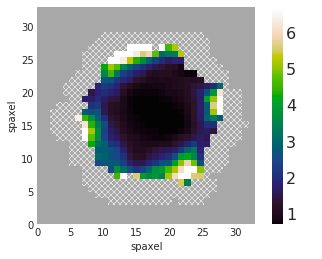

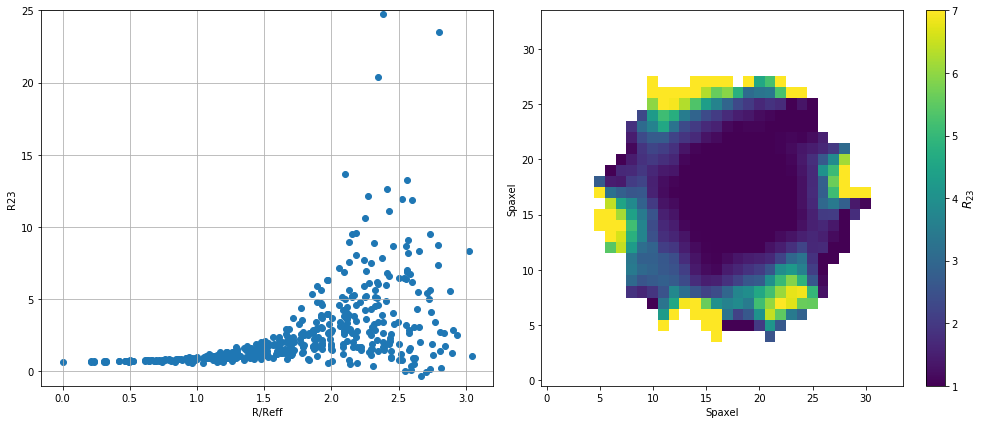

In [120]:
R23_255878 = R23_ratio(manga_id_list[2])
print(R23_255878.shape)
radius_255878 = R_Reff_ratio(manga_id_list[2])
print(radius_255878.shape)

fig, ax = R23_255878.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_255878, R23_255878.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-1,25)
#

img1 = ax1.imshow(R23_255878.value, aspect="auto", vmin=1, vmax=7)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()

<Marvin Maps (plateifu='8465-9102', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


(64, 64)
(64, 64)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


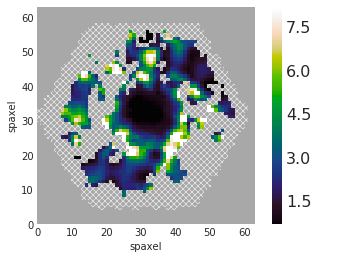

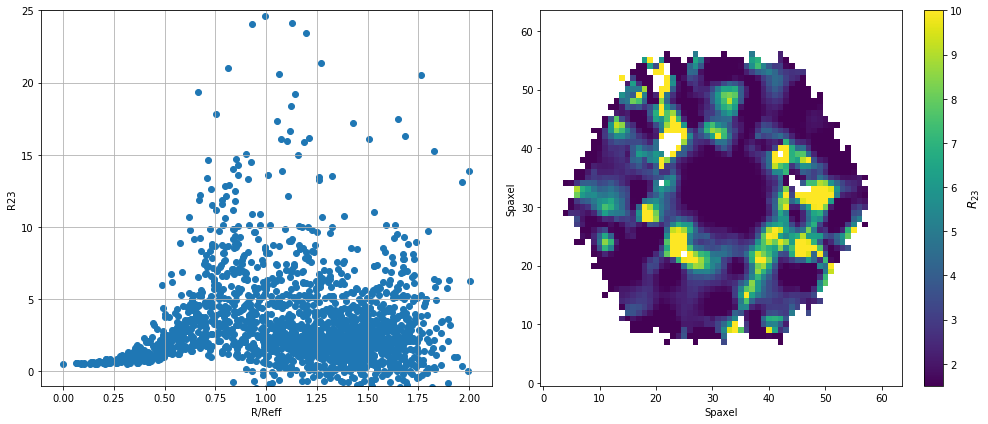

In [121]:
R23_284526 = R23_ratio(manga_id_list[3])
print(R23_284526.shape)
radius_284526 = R_Reff_ratio(manga_id_list[3])
print(radius_284526.shape)

fig, ax = R23_284526.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_284526, R23_284526.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-1,25)
#

img1 = ax1.imshow(R23_284526.value, aspect="auto", vmin=1.5, vmax=10)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()


<Marvin Maps (plateifu='8595-3703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>
(44, 44)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


(44, 44)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


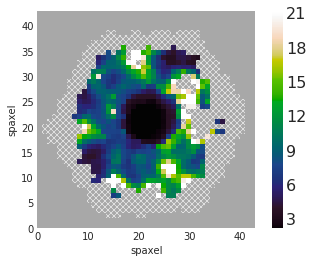

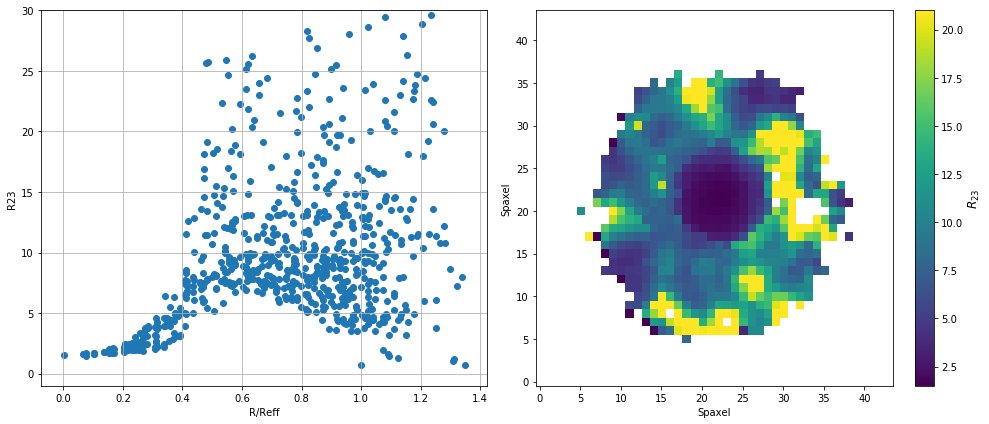

In [122]:
R23_631278 = R23_ratio(manga_id_list[4])
print(R23_631278.shape)
radius_631278 = R_Reff_ratio(manga_id_list[4])
print(radius_631278.shape)

fig, ax = R23_631278.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_631278, R23_631278.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-1,30)

img1 = ax1.imshow(R23_631278.value, aspect="auto", vmin=1.5, vmax=21)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()

<Marvin Maps (plateifu='8312-12704', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


(74, 74)
(74, 74)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


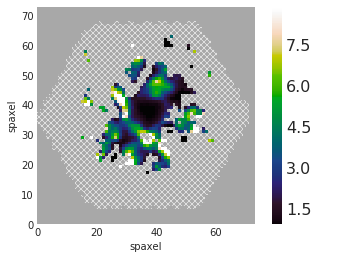

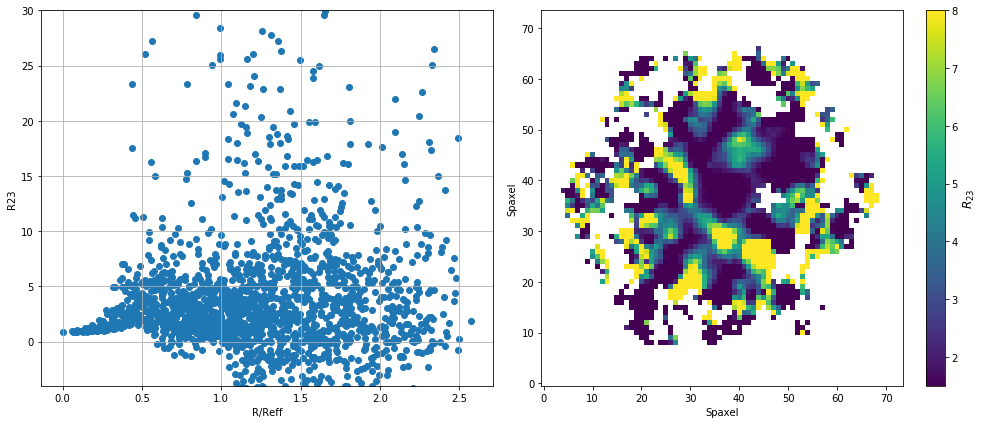

In [123]:
R23_633990 = R23_ratio(manga_id_list[5])
print(R23_633990.shape)
radius_633990 = R_Reff_ratio(manga_id_list[5])
print(radius_633990.shape)

fig, ax = R23_633990.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_633990, R23_633990.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-4,30)

img1 = ax1.imshow(R23_633990.value, aspect="auto", vmin=1.5, vmax=8)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()

<Marvin Maps (plateifu='8550-12703', mode='local', data_origin='file', bintype='HYB10', template='GAU-MILESHC')>


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


(76, 76)
(76, 76)


/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/Users/mmckay/conda/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


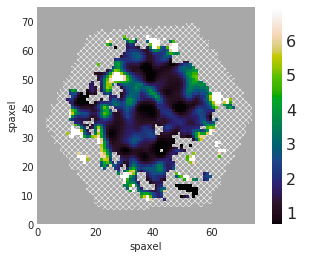

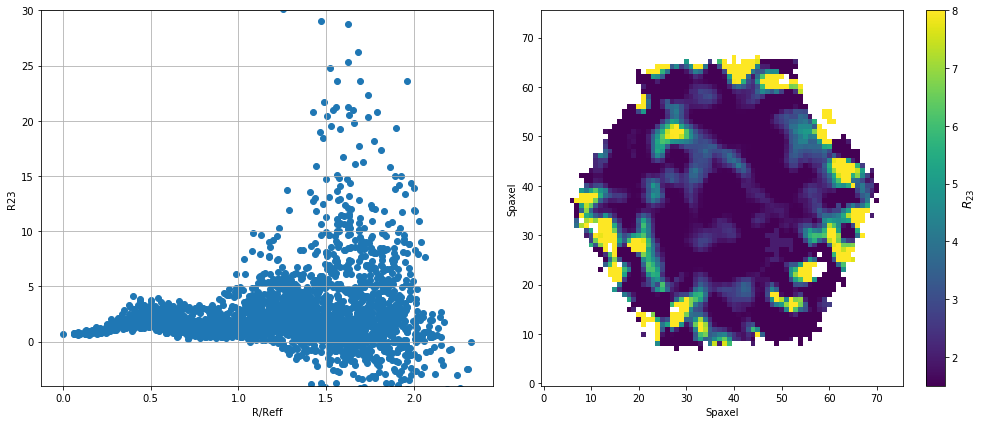

In [125]:
R23_135054 = R23_ratio(manga_id_list[6])
print(R23_135054.shape)
radius_135054 = R_Reff_ratio(manga_id_list[6])
print(radius_135054.shape)

fig, ax = R23_135054.plot()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.grid()
ax0.scatter(radius_135054, R23_135054.value)
ax0.set_xlabel('R/Reff')
ax0.set_ylabel('R23')
ax0.set_ylim(-4,30)

img1 = ax1.imshow(R23_135054.value, aspect="auto", vmin=1.5, vmax=8)
ax1.set_xlabel('Spaxel')
ax1.set_ylabel('Spaxel')
#plt.colorbar(im, fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=ax1).set_label(label='$R_{23}$', fontsize=12)#, fraction=0.046, pad=0.04)
#fig.suptitle('{}'.format(i))
fig.tight_layout(h_pad=4)
plt.gca().invert_yaxis()